In [40]:
%%capture
from tqdm.notebook import tqdm

import pickle
import json
import os
import numpy as np
import pandas as pd
import tensorflow as tf

random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)


binary_vectors_size = 8477

data_dir = 'data/'
preproc_path = data_dir + 'preprocessed/8477_vec_size/'

binary_path = preproc_path + 'binary/'
train_binary_path = binary_path + 'train/'
test_binary_path = binary_path + 'test/'

encoded_path = preproc_path + 'encoded_new/'
train_encoded_path = encoded_path + 'train/'
test_encoded_path = encoded_path + 'test/'

pooled_path = preproc_path + 'pooled/'

benign_dir = 'benign/'
malicious_dir = 'malicious/'

models_path = 'models/'

encoder_model_filename = 'encoder_lss3.3374e-02_dim8477_hls32_ils2048_bs64_e100+100+100+100+100_need_train_more_reg1.000e-05_drp0.6_optadadelta.h5'

In [41]:
from tensorflow.keras.models import load_model

def encode_binary_vectors(encoder_path):
    print('Binary vectors encoding...')
    encoder = load_model(encoder_path, compile=False)

    for dirpath, dirnames, filenames in os.walk(binary_path):
        npy_filenames = [x for x in filenames if x.endswith('.npy')]
        if not npy_filenames:
            continue

        dir_name = dirpath[len(binary_path):]
        output_path = os.path.join(encoded_path, dir_name)
        if not os.path.isdir(output_path):
            os.makedirs(output_path)

        for filename in tqdm(npy_filenames, desc=dir_name):
            vec_log = np.load(os.path.join(dirpath, filename))[:,:binary_vectors_size].astype(np.float64,copy=False)
            encoded_log = encoder.predict(vec_log)
            np.save(os.path.join(output_path, filename), encoded_log)

In [42]:
encoder_path = models_path + encoder_model_filename
encode_binary_vectors(encoder_path)

Binary vectors encoding...


In [43]:
def pool_encoded_features(dir_path):
    npy_filenames = [x for x in os.listdir(dir_path) if x.endswith('.npy')]
    ds = []
    for filename in npy_filenames:
        encoded_sample = np.load(dir_path + filename)
        #pooled_features = np.concatenate([np.min(encoded_sample, axis=0), np.max(encoded_sample, axis=0), np.mean(encoded_sample, axis=0)])
        pooled_features = np.max(encoded_sample, axis=0)

        ds.append(pooled_features)
        
    return np.stack(ds)


def get_labled_samples(dir_path):
    X_ben = pool_encoded_features(dir_path + benign_dir)
    y_ben = np.zeros(X_ben.shape[0], dtype=np.int)
    
    X_mal = pool_encoded_features(dir_path + malicious_dir)
    y_mal = np.ones(X_mal.shape[0], dtype=np.int)
    
    return np.concatenate([X_ben, X_mal], axis=0), np.concatenate([y_ben, y_mal])
    
    
def get_pooled_dataset(recreate=False):
    X_train_path = pooled_path + 'X_train.npy'
    y_train_path = pooled_path + 'y_train.npy'

    X_test_path = pooled_path + 'X_test.npy'
    y_test_path = pooled_path + 'y_test.npy'

    if not os.path.exists(pooled_path):
        os.makedirs(pooled_path)
            
    if os.path.exists(X_train_path) \
       and os.path.exists(y_train_path) and not recreate:
        
        X_train = np.load(X_train_path)
        y_train = np.load(y_train_path)
    else:
        print('Creating train dataset...')
        X_train, y_train = get_labled_samples(train_encoded_path)
        
        np.save(X_train_path, X_train)
        np.save(y_train_path, y_train)
    
    
    if os.path.exists(X_test_path) \
       and os.path.exists(y_test_path) and not recreate:
        
        X_test = np.load(X_test_path)
        y_test = np.load(y_test_path)
    else:
        print('Creating test dataset...')
        X_test, y_test = get_labled_samples(test_encoded_path)
        
        np.save(X_test_path, X_test)
        np.save(y_test_path, y_test)   
    
    return X_train, y_train, X_test, y_test

In [44]:
X_train, y_train, X_test, y_test = get_pooled_dataset(recreate=True)

Creating train dataset...
Creating test dataset...


In [45]:
print(X_train.shape, X_train.dtype, X_train.mean())
print(y_train.shape, y_train.dtype, y_train.mean(), np.unique(y_train))
print(X_test.shape, X_test.dtype, X_test.mean())
print(y_test.shape, y_test.dtype, y_test.mean(), np.unique(y_test))

(3792, 32) float32 681.584
(3792,) int32 0.4240506329113924 [0 1]
(948, 32) float32 762.88727
(948,) int32 0.4409282700421941 [0 1]


In [46]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, classification_report, confusion_matrix


param_grid = {'SVM__C': [1, 10, 100, 200, 400, 500, 1000],
              'SVM__gamma': [0.001, 0.01, 0.1, 0.3, 0.6, 0.8, 1, 2, 5, 10]}


cv = KFold(n_splits=5, shuffle=True, random_state=random_seed)

steps = [('scaler', StandardScaler()), ('SVM', SVC(kernel='rbf'))]
svm_pipeline = Pipeline(steps)

grid = GridSearchCV(svm_pipeline, param_grid, cv=cv.split(X_train, y_train), verbose=1)
grid.fit(X_train, y_train)

print(grid.best_params_)

best_model =  grid.best_estimator_
print(best_model.score(X_test, y_test))

Fitting 5 folds for each of 70 candidates, totalling 350 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:  7.3min finished


{'SVM__C': 200, 'SVM__gamma': 5}
0.5938818565400844


In [47]:
print(best_model.score(X_test, y_test))
y_pred = best_model.predict(X_test)
y_pred.shape

0.5938818565400844


(948,)

In [48]:
print(y_pred.dtype)
np.unique(y_pred, return_counts=True)

int32


(array([0, 1]), array([871,  77], dtype=int64))

In [24]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
print(fpr, tpr, thresholds)

              precision    recall  f1-score   support

           0       0.79      0.84      0.82       530
           1       0.78      0.72      0.75       418

    accuracy                           0.79       948
   macro avg       0.79      0.78      0.78       948
weighted avg       0.79      0.79      0.79       948

[[445  85]
 [115 303]]
[0.         0.16037736 1.        ] [0.         0.72488038 1.        ] [2 1 0]


[[445  85]
 [115 303]]


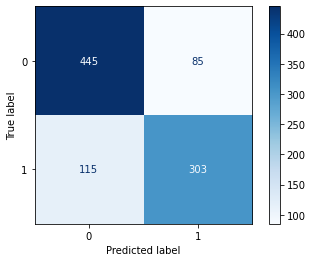

In [30]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

disp = plot_confusion_matrix(best_model, X_test, y_test,
                             cmap=plt.cm.Blues)

print(disp.confusion_matrix)

plt.show()